In [0]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import math

from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [0]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


# Get the data

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NN/Titanic/train.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
print('Survived ratio = ', len(data.loc[data.Survived==1]) / len(data) )

Survived ratio =  0.3838383838383838


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
data.describe()

# Prepare the data

In [0]:
def prepare_data(data):
  # Make female=0, male=1
  data['Sex'] = data['Sex'].map({'female':0, 'male':1}).astype(np.uint8)

  # check if Fare is NaN (need for data_test - only 1 man)
  data.loc[data.Fare.isna(), 'Fare'] = data.loc[data.Pclass==3, 'Fare'].mean()

  # One Hot Encoding for Pclass (Ticket class:	1 = 1st, 2 = 2nd, 3 = 3rd)
  data = pd.concat([data, pd.get_dummies(data['Pclass'], prefix='Pclass')],axis=1)
  data.drop(['Pclass'], axis=1, inplace=True)

  # One Hot Encoding for Embarked (C = Cherbourg, Q = Queenstown, S = Southampton)
  data = pd.concat([data, pd.get_dummies(data['Embarked'], prefix='Embarked')],axis=1)
  data.drop(['Embarked'], axis=1, inplace=True)

  '''
  # One Hot Encoding for Cabin - NOT GOOD because too low amount of data
  data['Cabin'] = data.Cabin.str[0]
  data.loc[data.Cabin == 'T', 'Cabin'] = np.nan
  data = pd.concat([data, pd.get_dummies(data['Cabin'], prefix='Cabin')],axis=1)
  data.drop(['Cabin'], axis=1, inplace=True)
  '''

  # Add new feature - Number of family members onboard
  #data['Family'] = data['SibSp'] + data['Parch'] # no corr with 'Survived'

  # Change titles to 4 types
  data['Title'] = data.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
  replaceit = ['Ms',   'Mlle', 'Mme', 'Dr', 'Don', 'Capt', 'Jonkheer', 'the Countess', 'Sir', 'Lady', 'Major',  'Col', 'Rev', 'Dona']
  withit    = ['Miss', 'Miss', 'Mrs', 'Mr', 'Mr',  'Mr',   'Mr',       'Mrs',          'Mr',  'Mrs',  'Mr',     'Mr',  'Mr' , 'Mrs' ]
  data['Title'] = data['Title'].replace(replaceit, withit)
  # One Hot Encoding for Title
  data = pd.concat([data, pd.get_dummies(data['Title'], prefix='Title')],axis=1)
  data.drop(['Name', 'Title'], axis=1, inplace=True)

  # Fill Age=NaN with mean() respectively to Title
  data.loc[ (data.Age.isna()) & (data.Title_Master) , 'Age'] = data.loc[data.Title_Master, 'Age'].mean()
  data.loc[ (data.Age.isna()) & (data.Title_Miss) , 'Age'] = data.loc[data.Title_Miss, 'Age'].mean()
  data.loc[ (data.Age.isna()) & (data.Title_Mr) , 'Age'] = data.loc[data.Title_Mr, 'Age'].mean()
  data.loc[ (data.Age.isna()) & (data.Title_Mrs) , 'Age'] = data.loc[data.Title_Mrs, 'Age'].mean()

  # drop colomns Ticket Cabin
  #print('Cabin unknown for ', data.Cabin.isna().sum())
  cols_to_drop = ['Ticket', 'Cabin']
  data = data.drop(cols_to_drop, axis=1)

  #idea from Sack of Potatoes
  data.Age = np.log(1 + data.Age)
  data.Fare = np.log(1 + data.Fare)
  
  return data

In [0]:
data = prepare_data(data)

# Уберем колонки, не коррелирующие с 'Survived'
drop_list_nocor = ['SibSp', 'Embarked_Q']
#drop_list_nocor = []

# Уберем колонки, не одинакого коррелирующе в train и test выборке
#drop_list_discor = ['Age']
drop_list_discor = []

cut_data = data.drop(['Survived', 'PassengerId'] + drop_list_nocor + drop_list_discor, axis=1)
X_data = cut_data.values
y_data = data['Survived'].values

# TSNE & PCA & Correlations

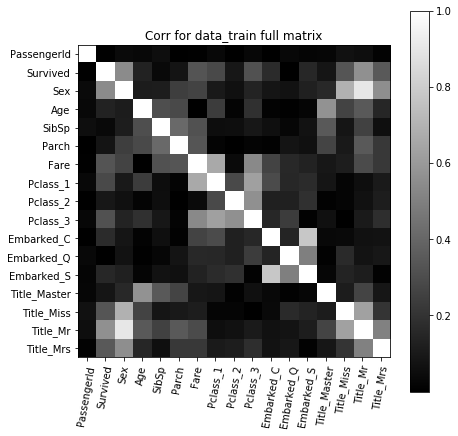

In [0]:
def plot_corr(data, title='Cor', mode='real'):
  plt.figure(figsize=(7, 7))
  if mode == 'real':
    plt.imshow(data, cmap='jet' )
  elif mode == 'abs':
    plt.imshow(data.abs(), cmap='gray' )
  elif mode == 'power2':
    plt.imshow(np.power(data, 2), cmap='jet' )
  else: print('Check the mode')
  plt.title(title)
  plt.yticks(ticks = np.arange(0,len(data.columns),1), labels = data.columns)
  plt.xticks(rotation=80)
  plt.xticks(ticks = np.arange(0,len(data.columns),1), labels = data.columns)
  plt.colorbar()
  plt.show()

# определим колонки, не коррелирующие с 'Survived' для train выборки
plot_corr(data.corr(), title='Corr for data_train full matrix', mode='abs')

In [0]:
from sklearn.manifold import TSNE
X_2d_TSNE = TSNE(n_components=2).fit_transform(X_data)
X_2d_TSNE.shape

(891, 2)

2d TSNE


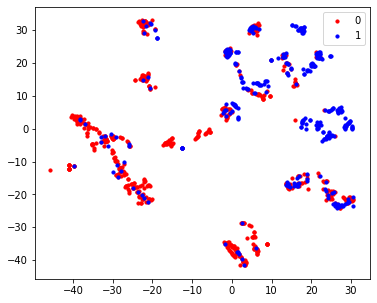

In [0]:
colors = 'r', 'b'

print('2d TSNE')
plt.figure(figsize=(6, 5))
for i, color in zip(range(2), colors):
    plt.scatter(X_2d_TSNE[y_data == i, 0], X_2d_TSNE[y_data == i, 1], s=10, c=color, label=str(i))
plt.legend()
plt.show()


In [0]:
from sklearn.decomposition import PCA
X_2d_PCA = PCA(n_components=2).fit(X_data).transform(X_data)
X_2d_PCA.shape

(891, 2)

2d TSNE


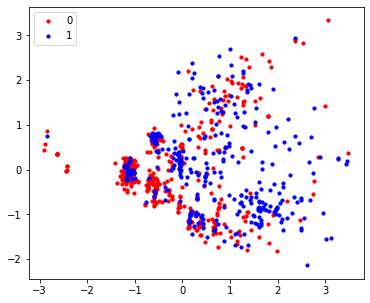

In [0]:
colors = 'r', 'b'

print('2d TSNE')
plt.figure(figsize=(6, 5))
for i, color in zip(range(2), colors):
    plt.scatter(X_2d_PCA[y_data == i, 0], X_2d_PCA[y_data == i, 1], s=10, c=color, label=str(i))
plt.legend()
plt.show()


# Test data preparation

In [0]:
data_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NN/Titanic/test.csv')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [0]:
# Приведем данные к тому же виду что train выборку
data_test = prepare_data(data_test)

# Уберем колонки, не коррелирующие с Survived
cut_data_test = data_test.drop(['PassengerId'] + drop_list_nocor + drop_list_discor, axis=1)
X_test = cut_data_test.values

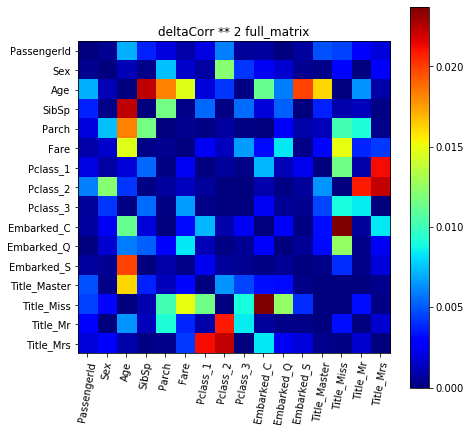

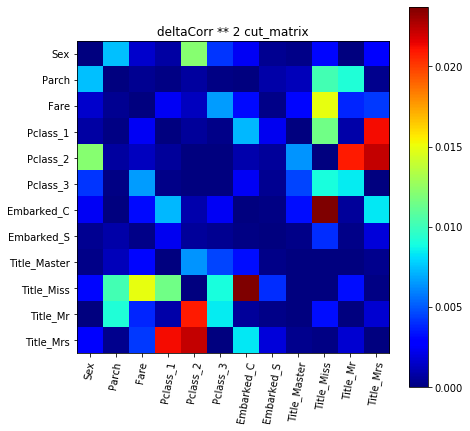

In [0]:
# определим колонки, не одинакого коррелирующие с данными для train и test выборки
#plot_corr(data.drop(['Survived'], axis=1).corr(), title='Corr data full_matrix', mode='real')
#plot_corr(data_test.corr(), title='Corr data_test full_matrix', mode='real')
plot_corr( data_test.corr() - data.drop(['Survived'], axis=1).corr() , title='deltaCorr ** 2 full_matrix', mode='power2')

plot_corr( cut_data_test.corr() - cut_data.corr() , title='deltaCorr ** 2 cut_matrix', mode='power2' )

# Preparing dataset for torch model

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=2e-1, shuffle=True)

In [0]:
class MyDataset(Dataset):
    def __init__(self, data, labels=None, mode='train'):
        super().__init__()
        self.data = data
        self.labels = labels
        self.mode = mode
        self.len_ = len(self.data)
    
    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        x = self.data[index]
        #if self.mode == 'train':
            #x = x + x*np.random.normal(loc=0.0, scale=0.02)
        x = torch.Tensor(x)
        if self.mode == 'train' or self.mode == 'val':
            y = self.labels[index]
            y = torch.tensor(y)
            return x, y
        elif self.mode == 'test':
            return x           

In [0]:
train_dataset = MyDataset(X_train, y_train, 'train')
val_dataset = MyDataset(X_val, y_val, 'val')

# Torch Model

In [0]:
class Model(torch.nn.Module):
    def __init__(self, insize, max_n):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(insize,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, max_n),
            nn.BatchNorm1d(max_n),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(max_n, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)   
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [0]:
import torchsummary
model = Model(X_data.shape[1], 512).to(DEVICE)
torchsummary.summary(model.to(DEVICE), (X_data.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,792
       BatchNorm1d-2                  [-1, 128]             256
         LeakyReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                  [-1, 512]          66,048
       BatchNorm1d-6                  [-1, 512]           1,024
         LeakyReLU-7                  [-1, 512]               0
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
      BatchNorm1d-10                  [-1, 256]             512
        LeakyReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                   [-1, 32]           8,224
      BatchNorm1d-14                   

In [0]:
def train(train_dataset, val_dataset, model, epochs, batch_size, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    acc = []
    log_template = "Finished epoch {ep:03d} | train_loss {t_loss:0.4f} | val_loss {v_loss:0.4f}"

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, val_loss, train_acc, val_acc))
        #print(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
           
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    val_loss = running_loss / processed_data
    val_acc = running_corrects.cpu().numpy() / processed_data

    return val_loss, val_acc

In [0]:
model = Model(X_data.shape[1], 512).to(DEVICE)
history = []
history =  train(train_dataset, val_dataset, model=model, epochs=30, batch_size=16, lr=1e-4)
#history += train(train_dataset, val_dataset, model=model, epochs=10, batch_size=16, lr=0.2e-4)
history += train(train_dataset, val_dataset, model=model, epochs=10, batch_size=16, lr=0.05e-4)
print('Done!')

Done!


In [0]:
#history += train(train_dataset, val_dataset, model=model, epochs=2, batch_size=16, lr=0.1e-3)
#history += train(train_dataset, val_dataset, model=model, epochs=2, batch_size=16, lr=0.01e-3)

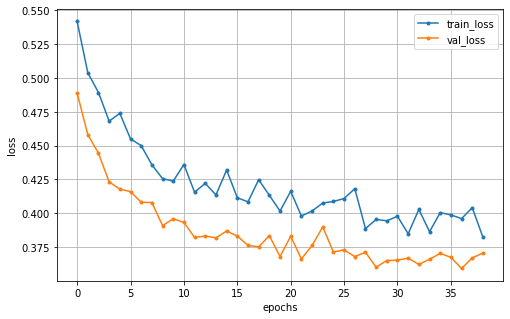

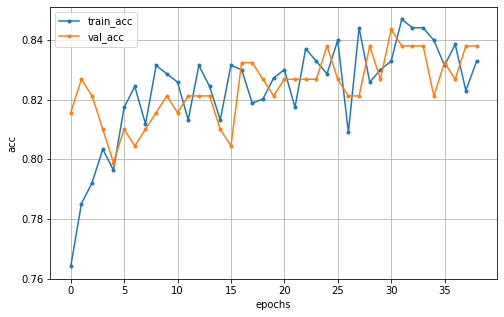

In [0]:
train_loss, val_loss, train_acc, val_acc = zip(*history)

plt.figure(figsize=(8, 5))
plt.plot(train_loss[1:], label="train_loss", marker='.')
plt.plot(val_loss[1:], label="val_loss", marker='.')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_acc[1:], label="train_acc", marker='.')
plt.plot(val_acc[1:], label="val_acc", marker='.')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()

# Test predictions

In [0]:
# для ансамбля моделей 

preds = torch.zeros((len(X_test),2))

for i in tqdm_notebook(range(20)):
  model = Model(X_test.shape[1], random.randint(512, 1024)).to(DEVICE)
  X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=2e-1, shuffle=True)
  train_dataset = MyDataset(X_train, y_train, 'train')
  val_dataset = MyDataset(X_val, y_val, 'train')
  history = []
  history =  train(train_dataset, val_dataset, model=model, epochs=30, batch_size=16, lr=1e-4)
  #history += train(train_dataset, val_dataset, model=model, epochs=10, batch_size=16, lr=0.2e-4)
  history += train(train_dataset, val_dataset, model=model, epochs=10, batch_size=16, lr=0.05e-4)
  model.eval()
  preds += model(torch.Tensor(X_test).to(DEVICE)).data.cpu()

preds = torch.argmax(preds, 1)


In [0]:
# Для одной модели
model.eval()
preds = model(torch.Tensor(X_test).to(DEVICE)).data.cpu()
preds = torch.argmax(preds, 1)

# KNN

Для одной модели:

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=2e-1, shuffle=True)

In [0]:
# Создадим стандартную KNN модель
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_val)
accuracy_score(y_val, preds)

0.8379888268156425

In [0]:
# обучение и кросс-валидация лучшей модели
cross_val_score(clf, X_data, y_data, cv=5, scoring='accuracy').mean()

0.8081225284037412

In [0]:
# Подберём лучшие параметры нашей модели
params = {'weights': ['uniform', 'distance'], 'n_neighbors': np.arange(1,11), 'metric': ['manhattan', 'euclidean']}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(X_data, y_data)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
# Выведем лучшие параметры
best = clf_grid.best_params_
best

{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}

In [0]:
# результат лучшей модели
optimal_clf = clf_grid.best_estimator_
optimal_clf.fit(X_train, y_train)
preds = optimal_clf.predict(X_val)
accuracy_score(y_val, preds)

0.8268156424581006

In [0]:
# обучение и кросс-валидация лучшей модели
cross_val_score(optimal_clf, X_data, y_data, cv=5, scoring='accuracy').mean()

0.8114744837110036

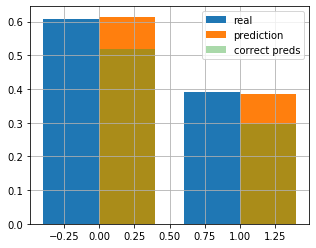

In [0]:
unique, freq = np.unique(y_val, return_counts=True)
freq = list(map(lambda x: x / len(y_val),freq))

pred_freq = [ (preds==0).sum()/len(preds) , (preds==1).sum()/len(preds) ]
correct_preds = [((preds==0) & (preds==y_val)).sum()/len(preds) , ((preds==1) & (preds==y_val)).sum()/len(preds)]

plt.figure(figsize=(5, 4))
plt.bar(range(0, 2), freq, width=-0.4, align="edge", label='real')
plt.bar(range(0, 2), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(0, 2), correct_preds, width=0.4, align="edge", label='correct preds', alpha=0.4)
plt.legend()
plt.grid()
plt.show()

Для ансамбля моделей:

In [0]:
sum_preds = np.zeros((len(X_test)))
treshold_acc = 0.82 # отсечка по желаемой точности
n_all_models = 100 # количество моделей в ансамбле
n_good_models = 0
mean_acc_score = 0

best = {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'} # посчитано выше, можно менять

for i in tqdm_notebook(range(n_all_models)):
  X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=2e-1, shuffle=True)

  optimal_clf = KNeighborsClassifier(metric=best['metric'], n_neighbors=best['n_neighbors'], weights=best['weights'])
  optimal_clf.fit(X_train, y_train)
  preds = optimal_clf.predict(X_val)
  acc = accuracy_score(y_val, preds)
  
  if acc > treshold_acc:
    n_good_models += 1
    mean_acc_score += acc 
    #print(i+1, acc)
    preds = optimal_clf.predict(X_test)
    sum_preds += preds

preds = np.rint(sum_preds/n_good_models) # округление
preds = np.array(preds, dtype=np.int)
mean_acc_score = mean_acc_score/n_good_models
print('for n_good_models =', n_good_models ,', mean_acc_score =', mean_acc_score)


for n_good_models = 31 , mean_acc_score = 0.8381690394665706


# Decision Tree

In [0]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=2e-1, shuffle=True)

Для одной модели:

In [0]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
print('train acc', clf.score(X_train, y_train))
print('val acc', clf.score(X_val, y_val))
print( 'cross val acc', cross_val_score(clf, X_data, y_data, cv=5, scoring='accuracy').mean() ) # обучается заново

train acc 0.8300561797752809
val acc 0.8435754189944135
cross val acc 0.8293892411022534


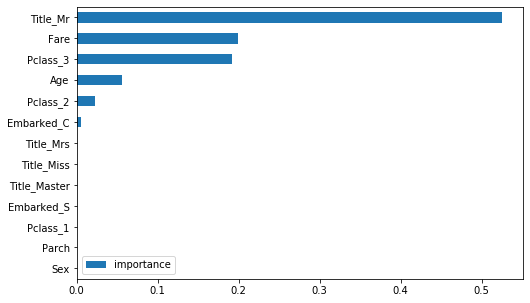

In [0]:
imp = pd.DataFrame(clf.feature_importances_, index=cut_data.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(8, 5))

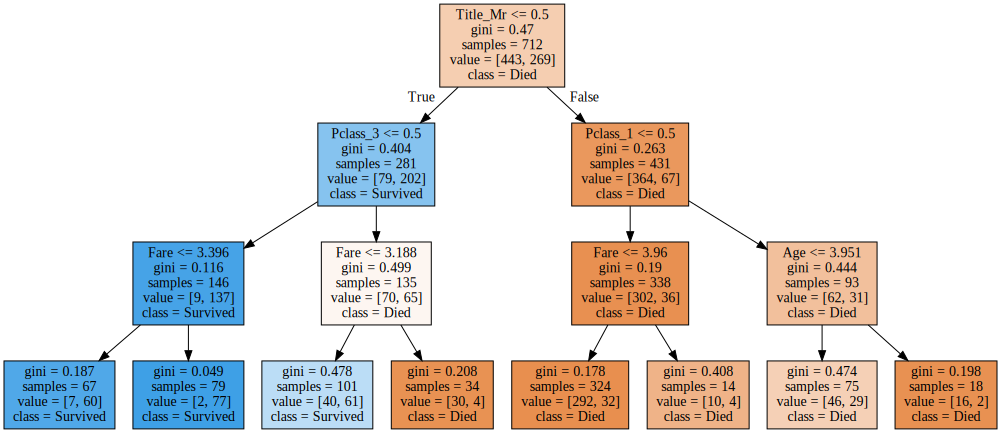

In [0]:
# показать граф
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(cut_data), class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [0]:
# или так
plt.figure(figsize=(100, 25))
tree.plot_tree(clf, fontsize=10, feature_names=list(cut_data), filled=True);

In [0]:
# определим оптмальную глубину дерева
params = {'criterion': ['gini', 'entropy'],
          'min_samples_leaf':range(2,50,2),
          'min_samples_split':range(2,101,2)}

for depth in range(2,6):
  clf = tree.DecisionTreeClassifier(max_depth = depth)

  # Подберём лучшие параметры нашей модели
  clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
  clf_grid.fit(X_data, y_data)

  # Выведем лучшие параметры
  best = clf_grid.best_params_
  print('for depth =', depth, best)

  # создание оптимальной модели
  clf = clf_grid.best_estimator_

  # вывод результатов (обучение при кросс валидации проводится заново)
  print('cross_val_acc {:.4f}'.format( cross_val_score(clf, X_data, y_data, cv=5, scoring='accuracy').mean() ))
  print()

for depth = 2 {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2}
cross_val_acc 0.7991

for depth = 3 {'criterion': 'gini', 'min_samples_leaf': 40, 'min_samples_split': 2}
cross_val_acc 0.8316

for depth = 4 {'criterion': 'entropy', 'min_samples_leaf': 14, 'min_samples_split': 80}
cross_val_acc 0.8373

for depth = 5 {'criterion': 'entropy', 'min_samples_leaf': 6, 'min_samples_split': 70}
cross_val_acc 0.8395



Для ансамбля моделей:

In [0]:
sum_preds = np.zeros((len(X_test)))
opt_depth = 3
best = {'criterion': 'gini', 'min_samples_leaf': 40, 'min_samples_split': 2}  # посчитано выше, можно менять

treshold_acc = 0.82 # отсечка по желаемой точности
n_all_models = 100 # количество моделей в ансамбле
n_good_models = 0
mean_acc_score = 0


for i in tqdm_notebook(range(n_all_models)):
  X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2e-1, shuffle=True)

  # обучение модели с оптимальными параметрами
  optimal_clf = tree.DecisionTreeClassifier(criterion=best['criterion'],
                                            min_samples_leaf=best['min_samples_leaf'],
                                            min_samples_split=best['min_samples_split'],
                                            max_depth = depth)
  optimal_clf.fit(X_train, y_train)
  preds = optimal_clf.predict(X_val)
  acc = accuracy_score(y_val, preds)
  
  if acc > treshold_acc:
    n_good_models += 1
    mean_acc_score += acc 
    #print(i+1, acc)
    preds = optimal_clf.predict(X_test)
    sum_preds += preds

preds = np.rint(sum_preds/n_good_models) # округление
preds = np.array(preds, dtype=np.int)
mean_acc_score = mean_acc_score/n_good_models
print('for n_good_models =', n_good_models ,', mean_acc_score =', mean_acc_score)



for n_good_models = 63 , mean_acc_score = 0.8783068783068777


# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=2e-1, shuffle=True)

In [0]:
param_dict = {'max_depth': range(4,9,1),
              'min_samples_leaf': range(4,21,4),
              'min_samples_split': range(20,41,4),
              'n_estimators': range(10,21,2) }

rf = RandomForestClassifier(random_state=0)
search = GridSearchCV(rf, param_dict, cv=5, n_jobs=-1, verbose=1)
search.fit(X_data, y_data)
search.best_params_

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:  1.9min finished


{'max_depth': 5,
 'min_samples_leaf': 8,
 'min_samples_split': 24,
 'n_estimators': 12}

In [0]:
best = {'max_depth': 5,
        'min_samples_leaf': 8,
        'min_samples_split': 24,
        'n_estimators': 12}

#rf = search.best_estimator_
rf = RandomForestClassifier(max_depth=best['max_depth'],
                            min_samples_leaf=best['min_samples_leaf'],
                            min_samples_split=best['min_samples_split'],
                            n_estimators=best['n_estimators'] )

In [0]:
rf.fit(X_train, y_train)
print('train acc', rf.score(X_train, y_train))
print('val acc', rf.score(X_val, y_val))
print( 'cross val acc', cross_val_score(rf, X_data, y_data, cv=5, scoring='accuracy').mean() ) # обучается заново

train acc 0.8202247191011236
val acc 0.8268156424581006
cross val acc 0.8170673529596385


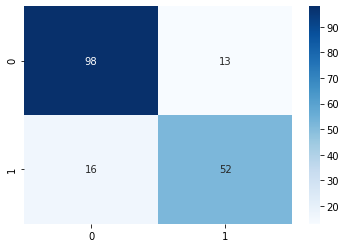

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

rf.fit(X_train, y_train)
preds_val = rf.predict(X_val)
sns.heatmap(confusion_matrix(y_val, preds_val), annot=True, cmap="Blues")

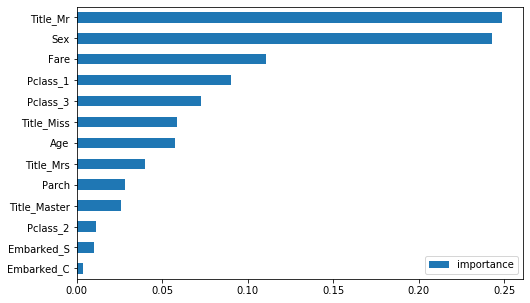

In [0]:
# значимость фичей при построении RandomForest
imp = pd.DataFrame(rf.feature_importances_, index=cut_data.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(8, 5))

In [0]:
# Финальное предсказание
rf.fit(X_data, y_data)
preds = rf.predict(X_test)

# Submit

In [0]:
my_submit = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': preds})
my_submit.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [0]:
my_submit.to_csv('/content/drive/My Drive/Colab Notebooks/NN/Titanic/my_submit.csv', index=False)